# Tutorial on Bayesian linear regression

**Alfredo Garbuno-Inigo**  
Phd student, University of Liverpool  
Institute for Risk and Uncertainty

## Bayesian data analysis

Being *Bayesian* in a statistical analysis means:
> Use probability to represent uncertainty in **all parts** of a statistical model.  

Probably the most **information-efficient** method for modeling.

Three main components:
* Data
* Data generative model 
* Prior 

It defines a **joint generative model** of **all variables** 
* *Unity among variables* - no distinction on data and parameters 
* *Unity among distributions* - the likelihood is not a *sided-shifted function*

## The Bayesics

![bayes](figs/perritos.png)
**Source:** Kruschke's book *Doing Bayesian Data Analysis*

## The linear regression model

From a frequentist point of view (*in matrix form*):

$$ Y = X\beta + \epsilon,$$ 

where $Y$ is the output of a linear combination of **predictors** $X$.

The coefficients $\beta$ are *unknown* but *fixed* quantities.  
The vector $\epsilon$ is the error term assumed to be normally distributed. (Zero mean, finite variance)

The solution is found by maximum likelihood estimation or ordinary least squares.

$$ \hat{\beta}_{\text{OLS}} = \left(X^\top X\right)^{-1}X^\top Y.$$ 

## Probabilistic reformulation

In a Bayesian setting, both $Y$ and $\beta$ are treated as random variables.  

The assumption of $Y$, being a random deviation from the linear model is the same.  

We extended to complete model through **prior beliefs** on the regression coefficients and the measurement noise.  

Finally, defining the complete model as 

$$
\begin{align}
Y \, | \, X, \beta, \sigma^2    &\sim \mathcal{N}(X\beta, \sigma^2), \\
\beta, \sigma^2 &\sim p(\beta, \sigma^2).
\end{align}
$$


### What do we gain? (other than more random variables?)

* Through priors we incorporate *whatever* knowledge we have on the parameters.  
* We can quantify uncertainty. 

    * The estimate of $\beta$ is not a single value.  
    * Through the posterior we have an idea of how likely other values are. 


In [1]:
%matplotlib inline
from pymc3 import *
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
size = 20

## An example

In [3]:
a = 1; b = 2
x = np.linspace(0, 1, size)

true_y = a + b * x

# add noise
y = true_y + np.random.normal(scale=.25, size=size)

In [4]:
data = dict(x=x, y=y)
axis_font = {'size':'16'}

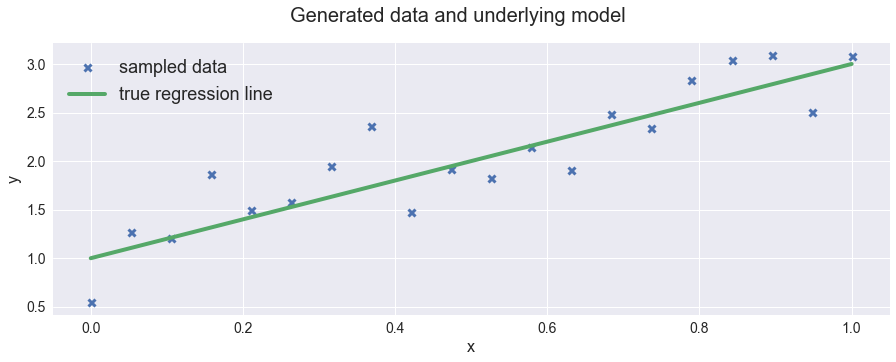

In [5]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
fig.suptitle('Generated data and underlying model', fontsize = 20)
ax.plot(x, y, 'x', label='sampled data', mew = 3)
ax.plot(x, true_y, label='true regression line', lw=4.)
plt.xlabel("x", **axis_font)
plt.ylabel("y", **axis_font)
plt.legend(loc=0, fontsize = 18);

## Computing the model

$$ 
\begin{align}
y_i & \sim \mathcal{N}(\mu, \sigma^2) \\
\mu & = \alpha + \beta x_i \\
\beta & \sim \mathcal{N}(0, 5) \\
\alpha & \sim \mathcal{N}(0, 5) \\
\sigma & \sim \text{Exponential}(1)
\end{align}
$$

In [14]:
with Model() as model:
    # Define priors ------------------------------------------------------------
    sigma = Exponential('sigma', 1)
    intercept = Normal('Intercept', 0, sd=5)
    x_coeff = Normal('x', 0, sd=5)
    
    # Define likelihood --------------------------------------------------------
    likelihood = Normal('y', mu=intercept + x_coeff * x, 
                        sd=sigma, observed=y)
    
    # Inference! ---------------------------------------------------------------
    trace = sample(3000, njobs=3)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 18.22:   7%|▋         | 14254/200000 [00:02<00:28, 6523.37it/s] 
Convergence archived at 14500
Interrupted at 14,500 [7%]: Average Loss = 48.67
100%|██████████| 3500/3500 [00:09<00:00, 357.99it/s]


## Looking at the results

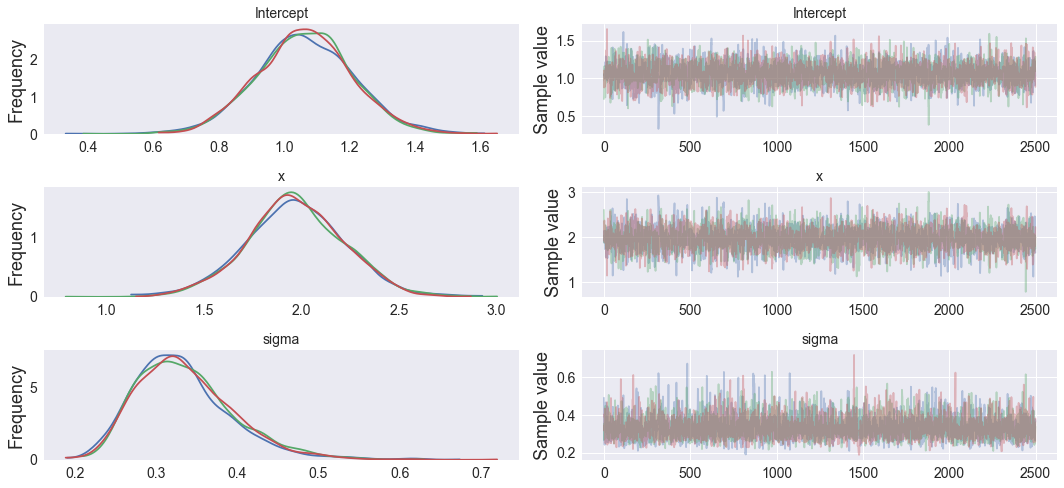

In [15]:
traceplot(trace[500:], figsize=(15, 7)); 
plt.tight_layout();

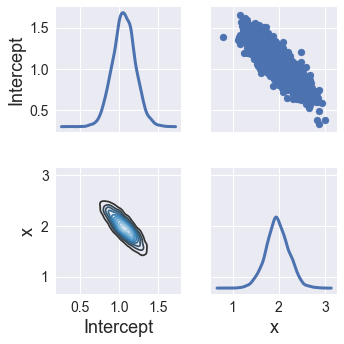

In [16]:
g = sns.PairGrid(pd.DataFrame({'x': trace[500:]['x'], 
                               'Intercept': trace[500:]['Intercept']
                              }));
g.map_lower(sns.kdeplot, cmap="Blues_d");
g.map_upper(plt.scatter);
g.map_diag(sns.kdeplot, lw=3);
plt.tight_layout();

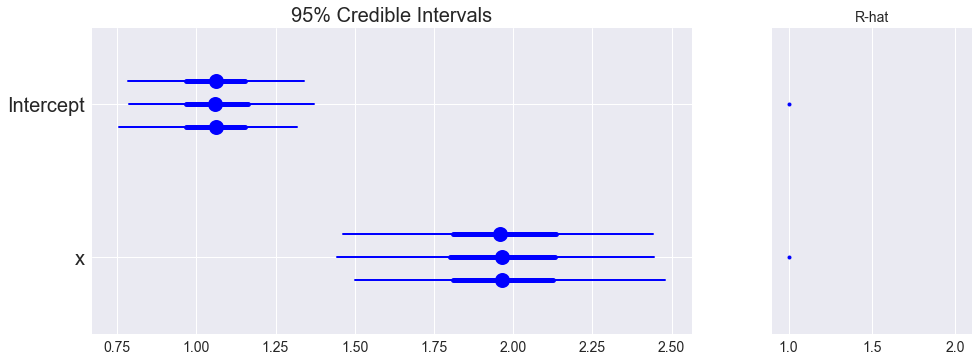

In [17]:
plt.figure(figsize=(15, 5))
plts = forestplot(trace, varnames=['Intercept','x'], 
                  fontsize = 20, linewidth = 5, 
                  marker = 'o', markersize = 15, 
                  chain_spacing = .15)
ax1 = plt.subplot(plts[0])
# ax1.grid(b=True, which='major', color='gray', linestyle='-', alpha = .7)

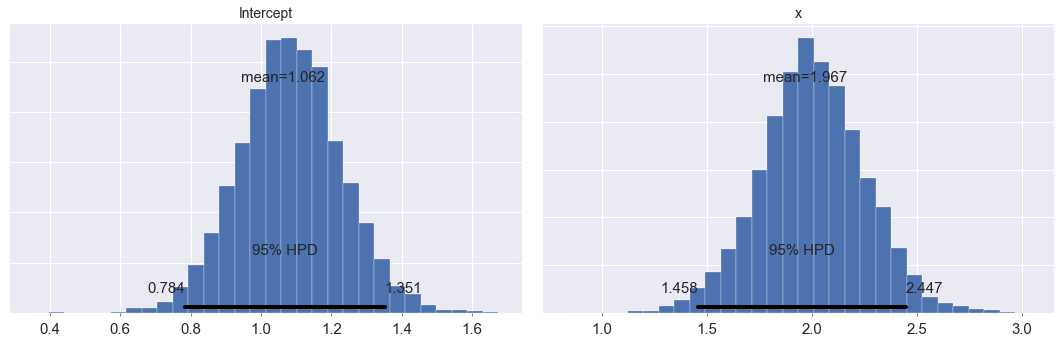

In [18]:
plot_posterior(trace, varnames=['Intercept','x'], text_size=15, figsize=(15, 5));

## Plotting our resulting linear models

In [19]:
a = trace[1000:]['Intercept']
b = trace[1000:]['x']
sigma = trace[1000:]['sigma']

index = np.random.randint(0,5000,100)

h = np.arange(0, 1.03, 0.03)

In [20]:
yhat = a[index, np.newaxis] + np.multiply(b[index,np.newaxis], h)
sampled_noise = np.random.normal(0, sigma[index], size = (2000,100))
ysim = sampled_noise[:,:,np.newaxis] + yhat
ysim = np.percentile(ysim, [2.5, 50, 97.5], axis =(0,1))
yhat = np.percentile(yhat, [2.5,50,97.5],axis = 0)

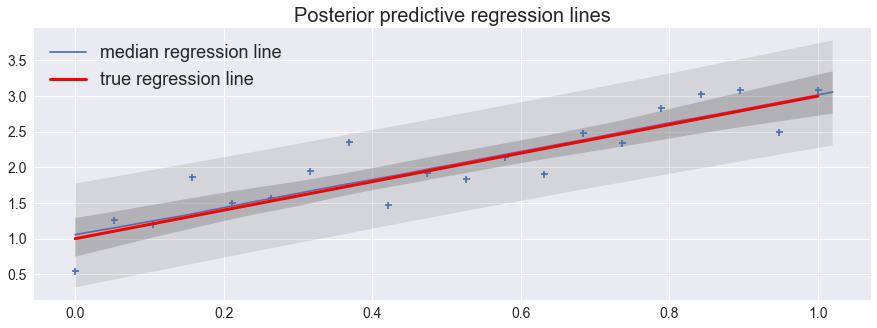

In [21]:
plt.figure(figsize=(15, 5));
plt.fill_between(h, ysim[0], ysim[2], facecolor='gray', alpha = 0.2);
plt.fill_between(h, yhat[0], yhat[2], facecolor='gray', alpha = 0.4);
plt.plot(h, yhat[1], label = 'median regression line');
plt.plot(x, true_y, label='true regression line', lw=3., c='r');
plt.scatter(x, y,  marker = '+');
plt.title('Posterior predictive regression lines', fontsize = 20)
plt.legend(loc=0, fontsize = 18);

## Extending the linear model

The linear regression model we have assumed is 

$$
\begin{align}
Y \, | \, X, \beta, \sigma^2    &\sim \mathcal{N}(X\beta, \sigma^2),\\
\beta, \sigma^2 &\sim p(\beta) \,  p(\sigma^2).
\end{align}
$$

Where the **mean parameter** of the Gaussian is **linear** in the predictors

$$ \mu = X\beta = \mathbb{E}[Y \, | \, X, \beta, \sigma ]$$

## First extension: *Generalized Linear Models (GLMs)*

What if we change the **probability distribution of the residuals**? 

Assume a **linear model** directly in the **canonical mean** parameter of the distribution  

$$ \mathbb{E}[Y \, |\, X, \boldsymbol\theta]. $$

Canonical in the sense of the **exponential family**.

The family of distributions that can be written as

$$ 
f(x\,|\,\boldsymbol\theta) = h(x) \, \exp\left( \, \boldsymbol {\color{blue} \eta (\boldsymbol\theta)} \cdot \boldsymbol T(x) - A(\boldsymbol \theta) \, \right) . 
$$


## Ingredients for *Generalized Linear Models (GLMs) *:

* A probability distribution from the exponential family.  

* A linear predictor $\eta = X \beta$.  

* A *link* function $\mathbb{E}[Y \, |\, X, \boldsymbol\theta] = g^{-1}(\eta)$ .

### An example: The binomial distribution

* The binomial distribution

$$ f(x) = \binom{n}{x} \, p^x \, (1-p)^{n-x}.$$

* The expected value is $\mathbb{E}[x] = p$.

* Can be written as

$$ f(x) = \binom{n}{x} \, \exp \left( x \log\left(\frac{p}{1-p}\right) + n \log(1-p)  \right). $$

* The canonical parameter is 

$$ \eta = \log \left( \frac{p}{1-p} \right).  $$

* It is also known as the *logit*.

## Second extension: *hierarchical models*

It is common that observational units are naturally **clustered**. 

Clustering induces **dependence between** observations, despite random sampling.  

### Pooling 
#### * ... one ring to rule them all!*

We assume that the data is sampled from the same model. This ignores any variation among sampling units (other than sampling variance):

![pooled](http://f.cl.ly/items/0R1W063h1h0W2M2C0S3M/Screen%20Shot%202013-10-10%20at%208.22.21%20AM.png)

### No pooling
#### *... the day we forsake our friends, we break all bonds of fellowship.* 

We assumed that the observational units come from different models. The differences between sampling units are to large to combine them:

![unpooled](http://f.cl.ly/items/38020n2t2Y2b1p3t0B0e/Screen%20Shot%202013-10-10%20at%208.23.36%20AM.png)


### Partial pooling (*aka* Hierarchical models, Multilevel models) 
#### *... what about side by side with a friend?*

The parameters are viewed as a sample from a distribution of parameters. Thus, we view them as being neither entirely.
different or exactly the same

![hierarchical](http://f.cl.ly/items/1B3U223i002y3V2W3r0W/Screen%20Shot%202013-10-10%20at%208.25.05%20AM.png)